# Clustering

### Due to the fact that we decided to use a subset of the data for this preliminary analysis, we will use the original dataframe without the rows that are not correct and we will correct them for the future analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

# Read in the data
final_clean = pd.read_csv('./dataset/data/final_clean.csv')

# Remember to the program which 🦆ing columns are objects
cat_cols = ['date_month', 'date_day', 'congressional_district', 'state', 'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']
final_clean[cat_cols] = final_clean[cat_cols].astype('object')


#show the number of rows and columns
final_clean.shape


(235176, 35)

In [2]:
adjusted_with_outliers = final_clean
adjusted_without_outliers = adjusted_with_outliers[adjusted_with_outliers['OUTLIER'] == 0]

print(f'adjusted_with_outliers shape: {adjusted_with_outliers.shape}\nadjusted_without_outliers shape: {adjusted_without_outliers.shape}')
print(final_clean.info())
cols_r = ['latitude', 'longitude', 'n_arrested', 'n_participants', 'timestamp', 'p_killed', 'p_injured', 'p_arrested', 'p_unharmed']
final_clean_r = final_clean[cols_r]

adjusted_with_outliers_r = final_clean_r
adjusted_without_outliers_r = adjusted_with_outliers_r[adjusted_with_outliers['OUTLIER'] == 0]

adjusted_with_outliers shape: (235176, 35)
adjusted_without_outliers shape: (77126, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235176 entries, 0 to 235175
Data columns (total 35 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   latitude                              235176 non-null  float64
 1   longitude                             235176 non-null  float64
 2   n_arrested                            235176 non-null  float64
 3   n_participants                        235176 non-null  float64
 4   timestamp                             235176 non-null  float64
 5   povertyPercentage                     235176 non-null  float64
 6   totalvotes                            235176 non-null  float64
 7   state_population                      235176 non-null  float64
 8   p_killed                              235176 non-null  float64
 9   p_injured                             235176 non

In [165]:
def features_reduction(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered

In [180]:
numeric_cols = final_clean.select_dtypes(include=['float64', 'int64']).columns

numeric_final_clean = final_clean[numeric_cols]

adjusted_with_outliers_r = features_reduction(numeric_final_clean, correlation_threshold=0.1)
adjusted_without_outliers_r = features_reduction(numeric_final_clean[final_clean['OUTLIER'] == 0], correlation_threshold=0.1)
print(adjusted_with_outliers_r.columns)
print(adjusted_without_outliers_r.columns)

Index(['latitude', 'longitude', 'n_arrested',
       'month_cd_change_max_age_participants'],
      dtype='object')
Index(['latitude', 'n_arrested', 'month_cd_change_max_age_participants'], dtype='object')


### We are left with a fraction of the original data, but it is still enough to work with, at least for this first part. 

---
---

# K-MEANS CLUSTERING

### We now use the K-means algorithm to cluster the data. We will use the silhouette score to find the optimal number of clusters.

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def k_means(df, n_samples=1, sample_size=1000, k_min=2, k_max=10, return_models=False):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    scoress = []
    models = [[], []]
    samples = [[], []]

    for i in range(0, k_max):
        models.append([])
        samples.append([])

    for i in range(0, n_samples):
        sample = numeric_df.sample(n=sample_size).copy()
        scores = []
        for k in tqdm(range(k_min, k_max+1)):
            kmeans = KMeans(n_clusters=k, n_init=10)
            labels = kmeans.fit_predict(sample)

            if return_models:
                models[k].append(kmeans)
                samples[k].append(sample)
                
            score = silhouette_score(sample, labels)
            scores.append(score)
            scoress.append(scores)

    scoress_array = np.array(scoress)
    mean_scores_array = np.mean(scoress_array, axis=0)
    mean_scores = mean_scores_array.tolist()

    return mean_scores, models, samples

In [266]:
def perform_PCA(df, n_components):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(numeric_df)

    # Create a PCA model
    pca = PCA(n_components=n_components)

    # Fit the model and transform the data
    df_pca = pca.fit_transform(df_scaled)

    # Create a DataFrame from the PCA results
    columns = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(df_pca, columns=columns)

    # Display the combined DataFrame
    return df_pca


adjusted_with_outliers_pca = perform_PCA(df=adjusted_with_outliers, n_components=3)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:24<00:00,  2.77s/it]


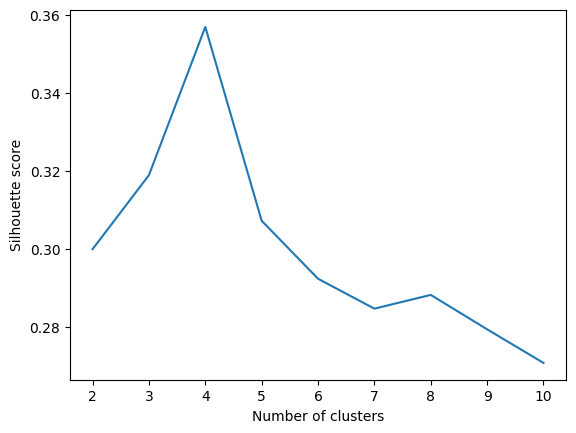

In [267]:
k_min = 2
k_max = 10

scores_with_outliers_pca, _, _ = k_means(df=adjusted_with_outliers_pca, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_with_outliers_pca)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [268]:
k_min = 4
k_max = 4

scores_with_outliers_pca, models_with_outliers_pca, points_with_outliers_pca = k_means(df=adjusted_with_outliers_pca, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


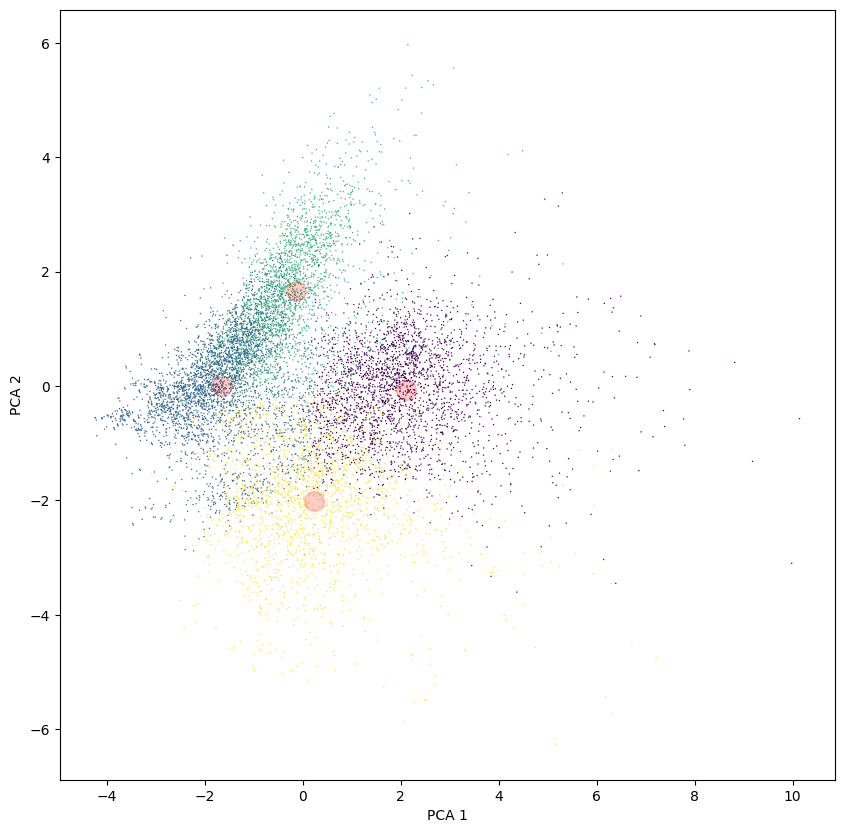

In [271]:
k=4

for i in range(0, 1):#len(models_with_outliers[k])):
    plt.figure(figsize=(10, 10))
    plt.scatter(points_with_outliers_pca[k][i].iloc[:, 0], points_with_outliers_pca[k][i].iloc[:, 2], c=models_with_outliers_pca[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(models_with_outliers_pca[k][i].cluster_centers_[:, 0], models_with_outliers_pca[k][i].cluster_centers_[:, 2], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:27<00:00,  3.00s/it]


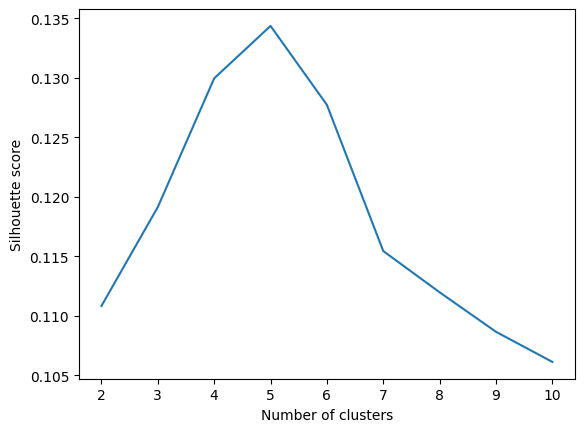

In [54]:
k_min = 2
k_max = 10

scores_with_outliers, _, _ = k_means(df=adjusted_with_outliers, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_with_outliers)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [110]:
k_min = 5
k_max = 5

scores_with_outliers, models_with_outliers, samples_with_outliers = k_means(df=adjusted_with_outliers, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

print(scores_with_outliers[0])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.10s/it]

0.1352362132211028


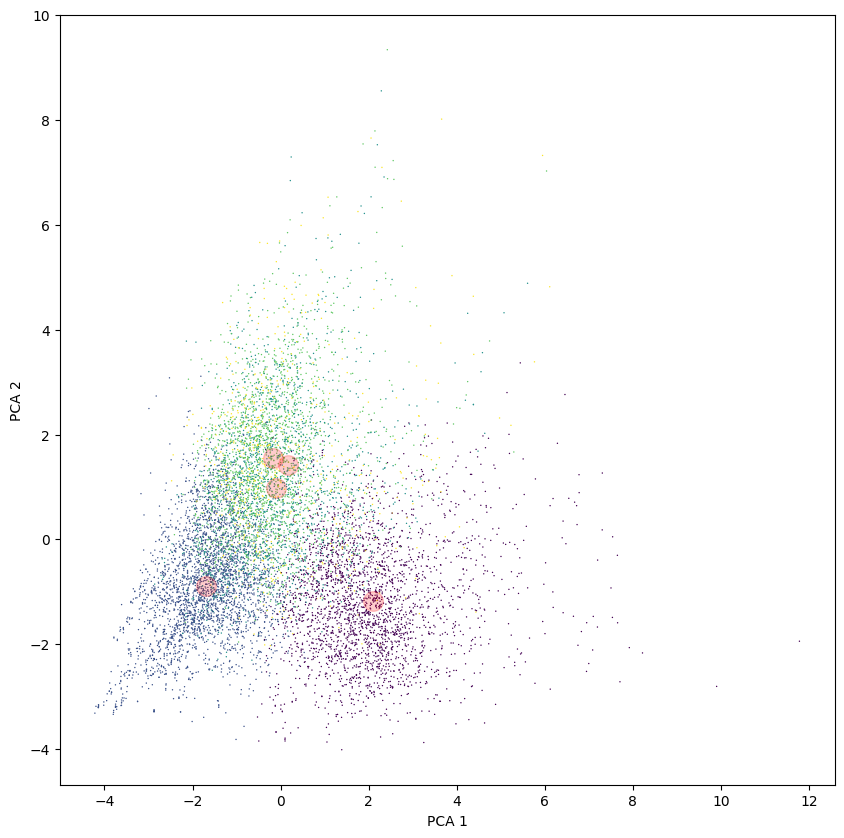

In [221]:
k = 5

for i in range(0, 1):#len(models_with_outliers[k])):
    pca = PCA(n_components=2)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(samples_with_outliers[k][i])
    sample_pca = pca.fit_transform(df_scaled)
    '''
    plt.scatter(sample_pca[:, 0], sample_pca[:, 1], c=models_with_outliers[k][i].labels_, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
    plt.title('KMeans Clustering Results (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    '''
    centroids_pca = pca.transform(models_with_outliers[k][i].cluster_centers_)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_pca[:, 0], sample_pca[:, 1], c=models_with_outliers[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:10<00:00,  7.88s/it]


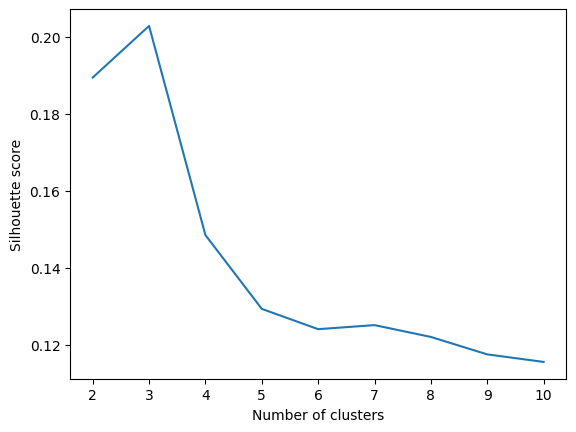

In [122]:
k_min = 2
k_max = 10

scores_without_outliers, _, _ = k_means(df=adjusted_without_outliers, n_samples=10, sample_size=20000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_without_outliers)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [125]:
k_min = 3
k_max = 3

scores_without_outliers, models_without_outliers, samples_without_outliers = k_means(df=adjusted_without_outliers, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)
print(scores_without_outliers[0])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

0.2020658358204106


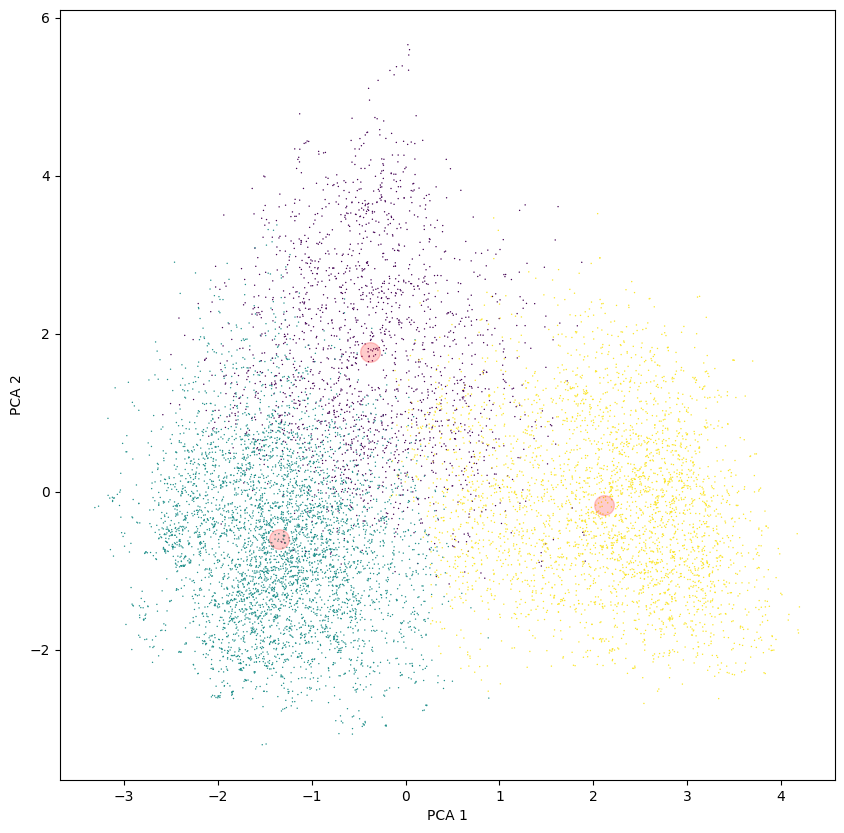

In [128]:
k = 3

for i in range(0, 1):#len(models_without_outliers[k])):
    pca = PCA(n_components=2)
    sample_pca = pca.fit_transform(samples_without_outliers[k][i].values)

    centroids_pca = pca.transform(models_without_outliers[k][i].cluster_centers_)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_pca[:, 0], sample_pca[:, 1], c=models_without_outliers[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:24<00:00,  2.73s/it]


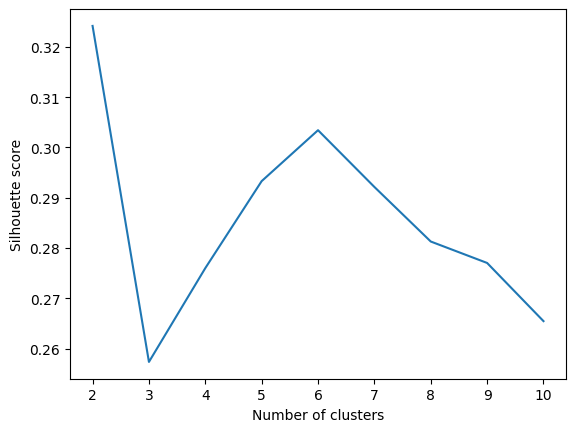

In [181]:
k_min = 2
k_max = 10

scores_with_outliers_r, _, _ = k_means(df=adjusted_with_outliers_r, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_with_outliers_r)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


0.29153852864448504


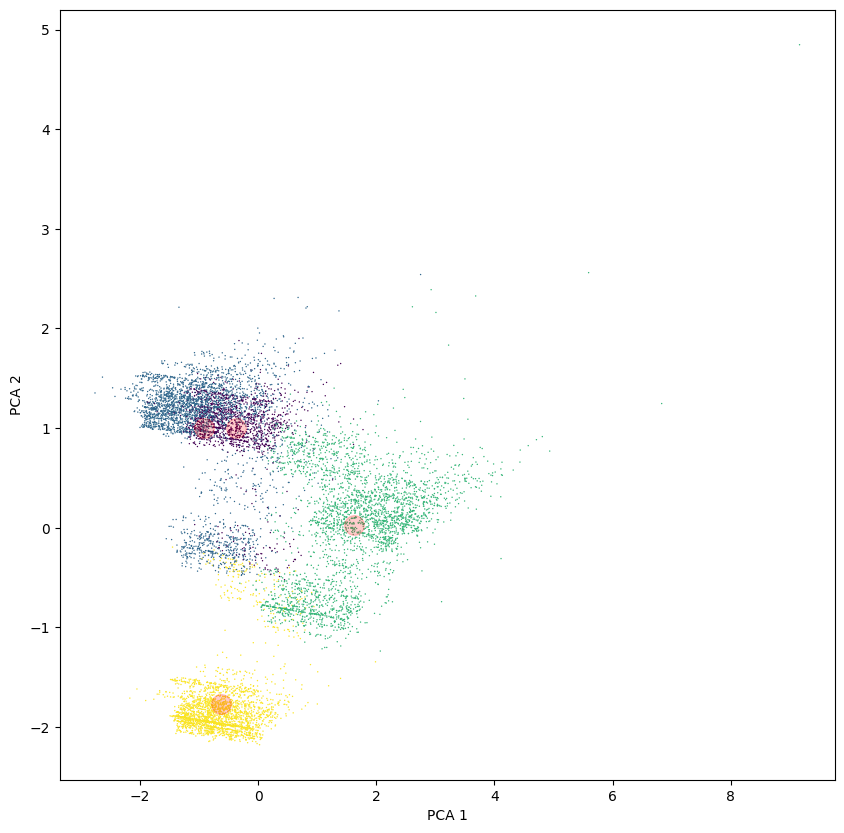

In [159]:
k_min = 4
k_max = 4

scores_with_outliers_r, models_with_outliers_r, samples_with_outliers_r = k_means(df=adjusted_with_outliers_r, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)
print(scores_with_outliers_r[0])
k = 4

for i in range(0, 1):#len(models_without_outliers[k])):
    pca = PCA(n_components=2)
    sample_pca = pca.fit_transform(samples_with_outliers_r[k][i].values)

    centroids_pca = pca.transform(models_with_outliers_r[k][i].cluster_centers_)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_pca[:, 0], sample_pca[:, 1], c=models_with_outliers_r[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

100%|██████████| 9/9 [00:22<00:00,  2.54s/it]


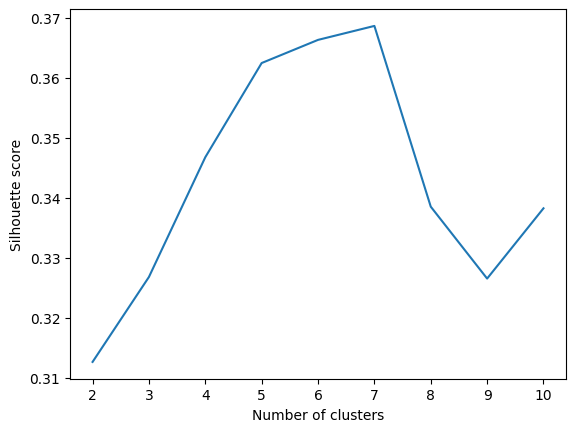

In [182]:
k_min = 2
k_max = 10

scores_without_outliers_r, _, _ = k_means(df=adjusted_without_outliers_r, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_without_outliers_r)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


0.37000790285982593


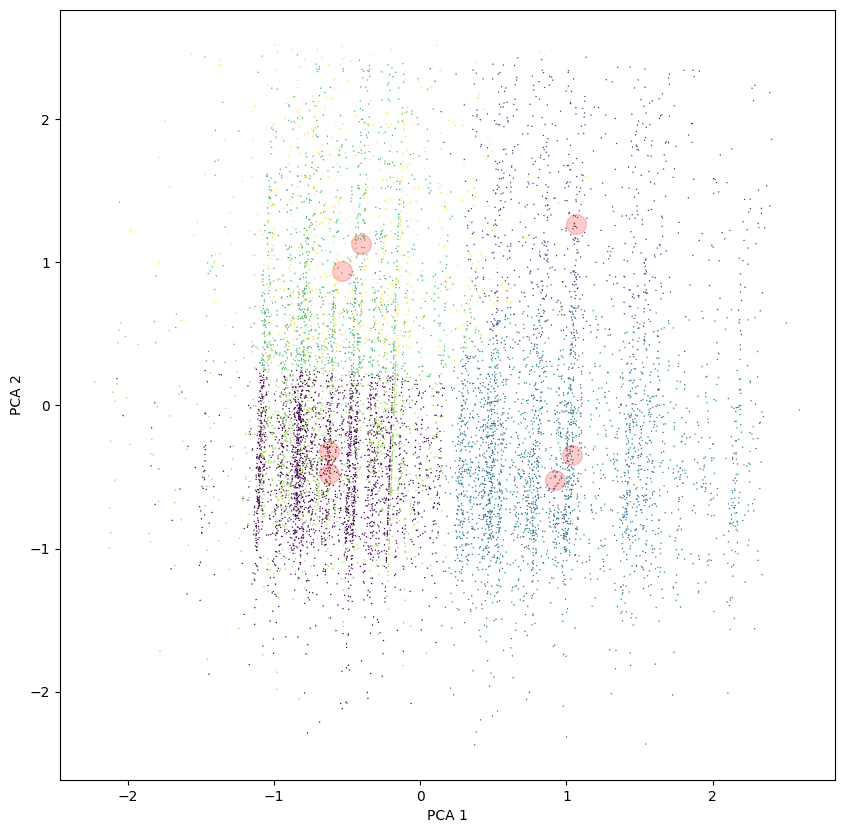

In [183]:
k_min = 7
k_max = 7

scores_without_outliers_r, models_without_outliers_r, samples_without_outliers_r = k_means(df=adjusted_without_outliers_r, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)
print(scores_without_outliers_r[0])
k = 7

for i in range(0, 1):#len(models_without_outliers[k])):
    pca = PCA(n_components=2)
    sample_pca = pca.fit_transform(samples_without_outliers_r[k][i].values)

    centroids_pca = pca.transform(models_without_outliers_r[k][i].cluster_centers_)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_pca[:, 0], sample_pca[:, 1], c=models_without_outliers_r[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

In [4]:
import random

def find_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    random.shuffle(columns)
    prev_max_score = -1
    actual_cols = []
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_score = max(scores)
        if prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score

In [5]:
cols, score = find_features(adjusted_with_outliers)
print(cols)
print(score)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


p_arrested added
actual score: 0.9949790664542268


100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


cd_month_SHOT_INJURED discarded
actual score: 0.5125794053570455


100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


month_cd_ratio_arrested discarded
actual score: 0.8575498619531904


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


cd_population discarded
actual score: 0.5198805287968051


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


cd_month_NON_SHOOTING discarded
actual score: 0.5707630996065123


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


cd_month_OTHER discarded
actual score: 0.5477062494151462


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


timestamp discarded
actual score: 0.5579168287374924


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


percentage_democrat discarded
actual score: 0.5459235333590926


100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


n_arrested discarded
actual score: 0.9688957772099587


100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


povertyPercentage discarded
actual score: 0.5367111706963018


100%|██████████| 8/8 [00:19<00:00,  2.38s/it]


month_cd_votes_incidents discarded
actual score: 0.9550777283643638


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


totalvotes discarded
actual score: 0.5250773207752243


100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


month_cd_ratio_participants_adult discarded
actual score: 0.6565164141684608


100%|██████████| 8/8 [00:19<00:00,  2.44s/it]


month_cd_ratio_killed discarded
actual score: 0.8424786191061608


100%|██████████| 8/8 [00:20<00:00,  2.53s/it]


latitude discarded
actual score: 0.5555816248413228


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


p_killed discarded
actual score: 0.9459048257616229


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


n_participants discarded
actual score: 0.8954939994231282


100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


month_cd_incidents discarded
actual score: 0.6382736315041142


100%|██████████| 8/8 [00:19<00:00,  2.45s/it]


month_cd_ratio_unharmed discarded
actual score: 0.7979953705580413


100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


month_cd_change_max_age_participants discarded
actual score: 0.537764466977447


100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


state_population discarded
actual score: 0.6621056019968873


100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


longitude discarded
actual score: 0.6149708382475224


100%|██████████| 8/8 [00:18<00:00,  2.34s/it]


p_unharmed discarded
actual score: 0.9369913296051752


100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


cd_month_SHOT_DEAD discarded
actual score: 0.5212667009277555


100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


p_injured discarded
actual score: 0.9247579539609037


100%|██████████| 8/8 [00:18<00:00,  2.31s/it]

month_cd_ratio_injured discarded
actual score: 0.7469008514837424
['p_arrested']
0.9949790664542268


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:22<00:00,  2.52s/it]


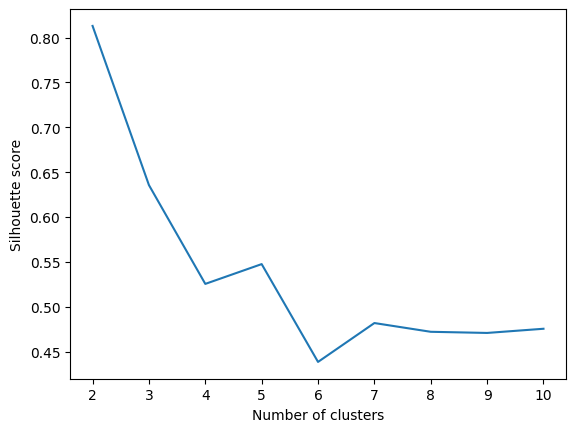

In [205]:
k_min = 2
k_max = 10

scores_with_outliers_r, _, _ = k_means(df=adjusted_with_outliers[cols], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_with_outliers_r)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [1]:
k_min = 2
k_max = 2

scores_with_outliers_r, models_with_outliers_r, samples_with_outliers_r = k_means(df=adjusted_with_outliers[cols], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)
print(scores_with_outliers_r[0])
k = 2

for i in range(0, 1):#len(models_without_outliers[k])):
    pca = PCA(n_components=2)
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(samples_with_outliers_r[k][i])
    sample_pca = pca.fit_transform(df_scaled)

    centroids_pca = pca.transform(models_with_outliers_r[k][i].cluster_centers_)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_pca[:, 0], sample_pca[:, 1], c=models_with_outliers_r[k][i].labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

NameError: name 'k_means' is not defined

In [215]:
cols, score = find_features(adjusted_without_outliers)
print(cols)
print(score)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


latitude added
actual score: 0.6662111428394621


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


longitude discarded
actual score: 0.4899885882089555


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


n_arrested discarded
actual score: 0.6069985006718351


100%|██████████| 8/8 [00:19<00:00,  2.38s/it]


n_participants discarded
actual score: 0.5675229752871357


100%|██████████| 8/8 [00:23<00:00,  2.91s/it]


timestamp discarded
actual score: 0.4122893452866928


100%|██████████| 8/8 [00:20<00:00,  2.62s/it]


povertyPercentage discarded
actual score: 0.532729218007002


100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


totalvotes discarded
actual score: 0.4218638393618304


100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


state_population discarded
actual score: 0.5126878778594569


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


p_killed discarded
actual score: 0.6453316067738301


100%|██████████| 8/8 [00:19<00:00,  2.48s/it]


p_injured discarded
actual score: 0.5944821858153144


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]


p_arrested discarded
actual score: 0.6098901447668726


100%|██████████| 8/8 [00:20<00:00,  2.52s/it]


p_unharmed discarded
actual score: 0.6114621469624116


100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


month_cd_change_max_age_participants discarded
actual score: 0.437615947528056


100%|██████████| 8/8 [00:17<00:00,  2.14s/it]


month_cd_ratio_participants_adult discarded
actual score: 0.6095177972997634


100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


month_cd_ratio_killed discarded
actual score: 0.6610447388126383


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


month_cd_ratio_injured discarded
actual score: 0.5640158632068335


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


month_cd_ratio_arrested discarded
actual score: 0.5812835077342465


100%|██████████| 8/8 [00:18<00:00,  2.32s/it]


month_cd_ratio_unharmed discarded
actual score: 0.6124587736477288


100%|██████████| 8/8 [00:20<00:00,  2.54s/it]


month_cd_incidents discarded
actual score: 0.5189638930587411


100%|██████████| 8/8 [00:19<00:00,  2.47s/it]


month_cd_votes_incidents discarded
actual score: 0.6625466840520958


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


cd_population discarded
actual score: 0.4278698312546033


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


percentage_democrat discarded
actual score: 0.4392594393919604


100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


cd_month_SHOT_INJURED discarded
actual score: 0.40699095405365326


100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


cd_month_SHOT_DEAD discarded
actual score: 0.4401506624860886


100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


cd_month_NON_SHOOTING discarded
actual score: 0.4360235049260117


100%|██████████| 8/8 [00:19<00:00,  2.44s/it]

cd_month_OTHER discarded
actual score: 0.4338618525670656
['latitude']
0.6662111428394621


100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


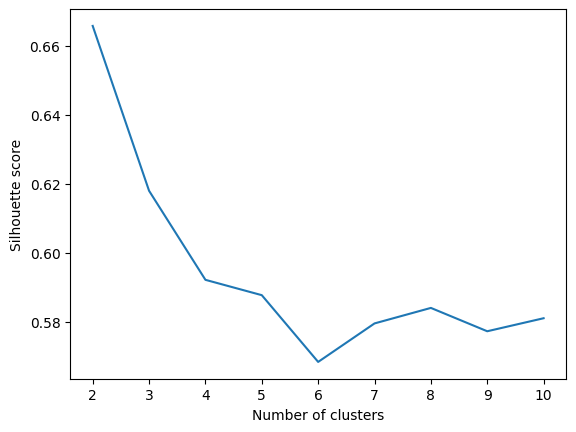

In [216]:
k_min = 2
k_max = 10

scores_without_outliers_r, _, _ = k_means(df=adjusted_without_outliers[cols], n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_without_outliers_r)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [130]:
def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:24<00:00,  2.68s/it]


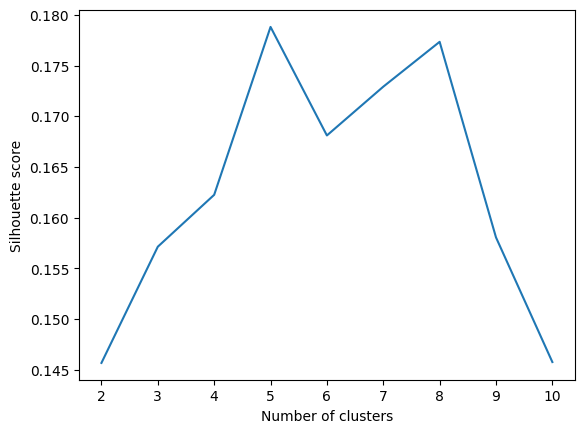

In [134]:
k_min = 2
k_max = 10

scores_with_outliers_r, models_with_outliers_r, points_with_outliers_r = k_means(df=sample_columns(adjusted_with_outliers, num_columns_to_sample=10), n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max)

plt.plot(range(k_min, k_max+1), scores_with_outliers_r)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
k = 5

for i in range(0, len(models_with_outliers[k])):
    model = models_with_outliers[k][i]
    points = samples_with_outliers[k][i]
    centroids = model.cluster_centers_
    labels = model.labels_

    # Randomly sample two dimensions
    random_dimensions = np.random.choice(points.columns[:-1], size=2, replace=False)

    # Plot the clustering in the randomly sampled dimensions
    plt.scatter(points[random_dimensions[0]], points[random_dimensions[1]], c=labels, cmap='viridis', edgecolors='k', s=50, alpha=0.7)
    plt.title(f'KMeans Clustering in Dimensions {random_dimensions[0]} and {random_dimensions[1]}')
    plt.xlabel(random_dimensions[0])
    plt.ylabel(random_dimensions[1])
    plt.show()

### As we can see from the graph, the optimal number of clusters is 3, because it's the highest point of the curve.
### We will use 3 as the number of clusters for the K-means algorithm, and we will use PCA to reduce the dimensionality of the data to 2, so we can plot the clusters.


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


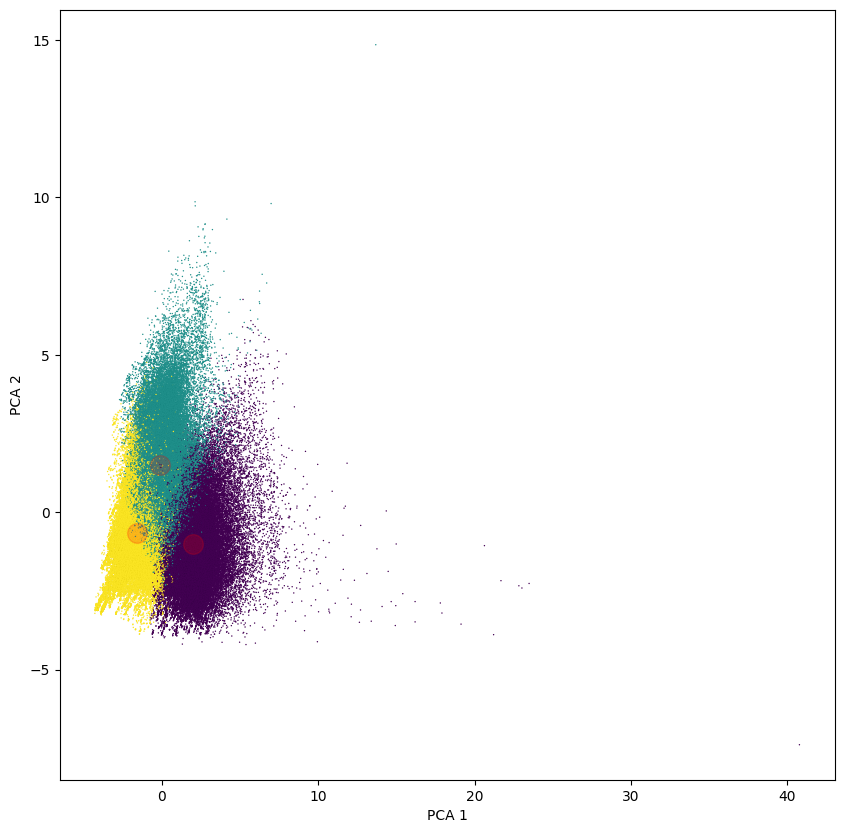

In [19]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

numeric_cols = final_clean.select_dtypes(include=['float64', 'int64']).columns
numeric_scaled = final_clean[numeric_cols]

# PCA
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_scaled)

# KMeans
scores = []
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(numeric_scaled)

centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], c=kmeans.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', s=200, alpha=0.2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()



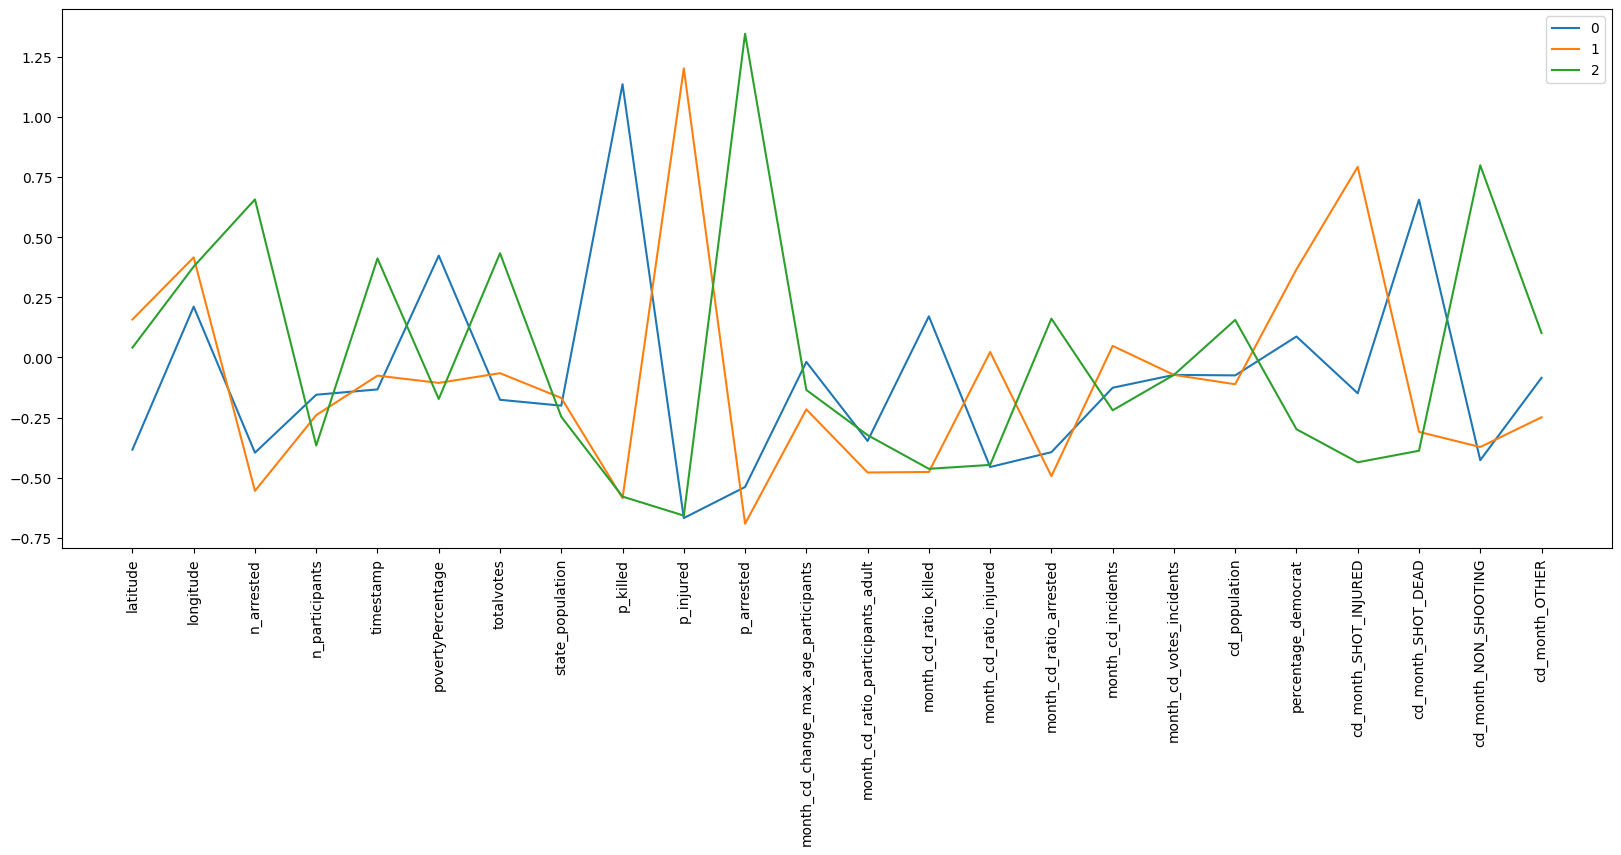

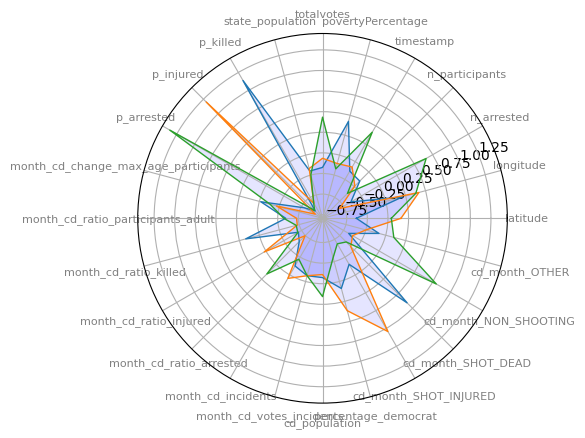

In [5]:
#Let's visualize the centroids of each cluster in the original feature space with two plots: a line plot and a radar plot.
plt.figure(figsize=(20, 7))
tran = kmeans.cluster_centers_
plt.plot(tran.T)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation='vertical')
plt.legend(range(k))
plt.show()

from math import pi
 
# number of variable
N = len(numeric_scaled.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(kmeans.cluster_centers_)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = kmeans.cluster_centers_[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the radar plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_scaled.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

### The following graphs will show the values of each attribute for each cluster

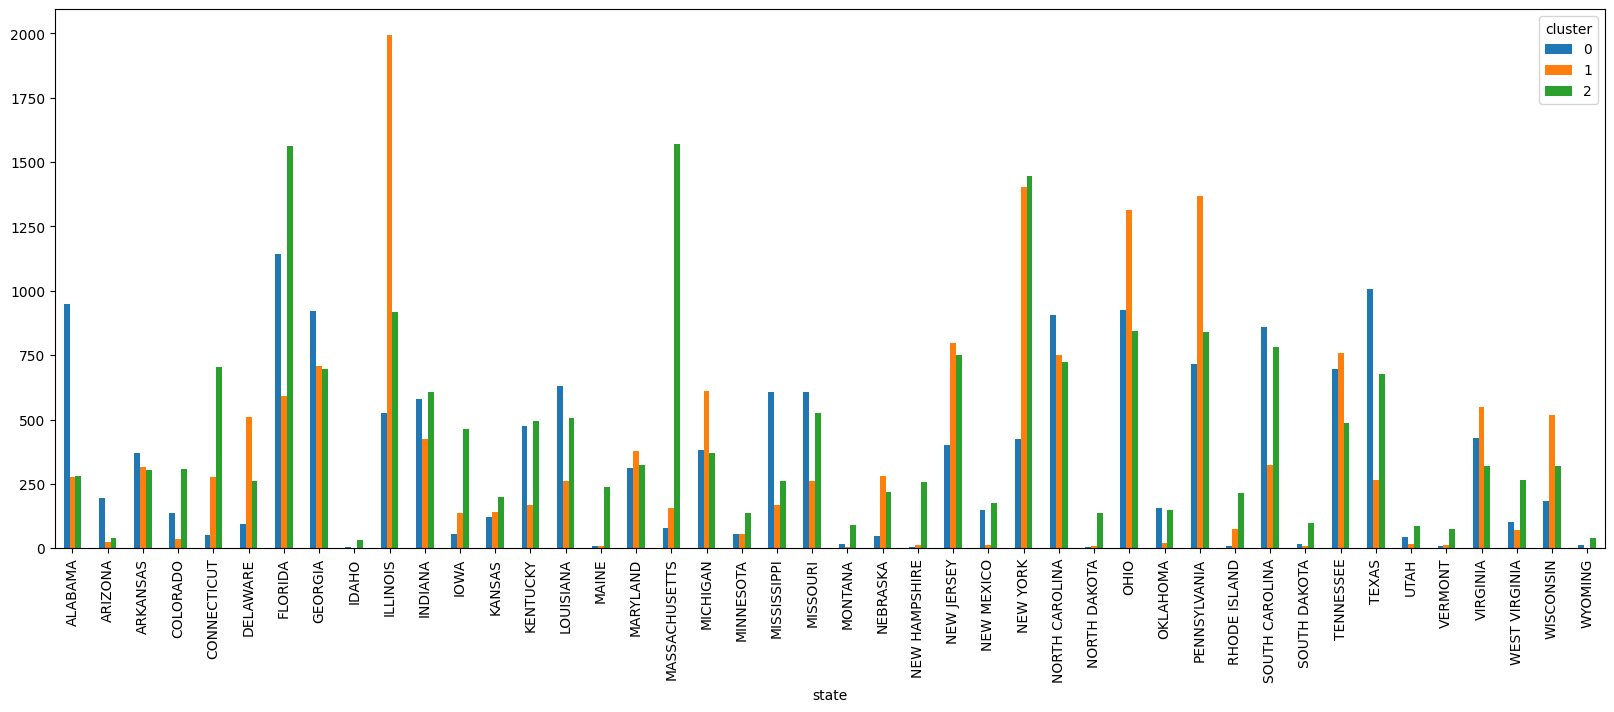

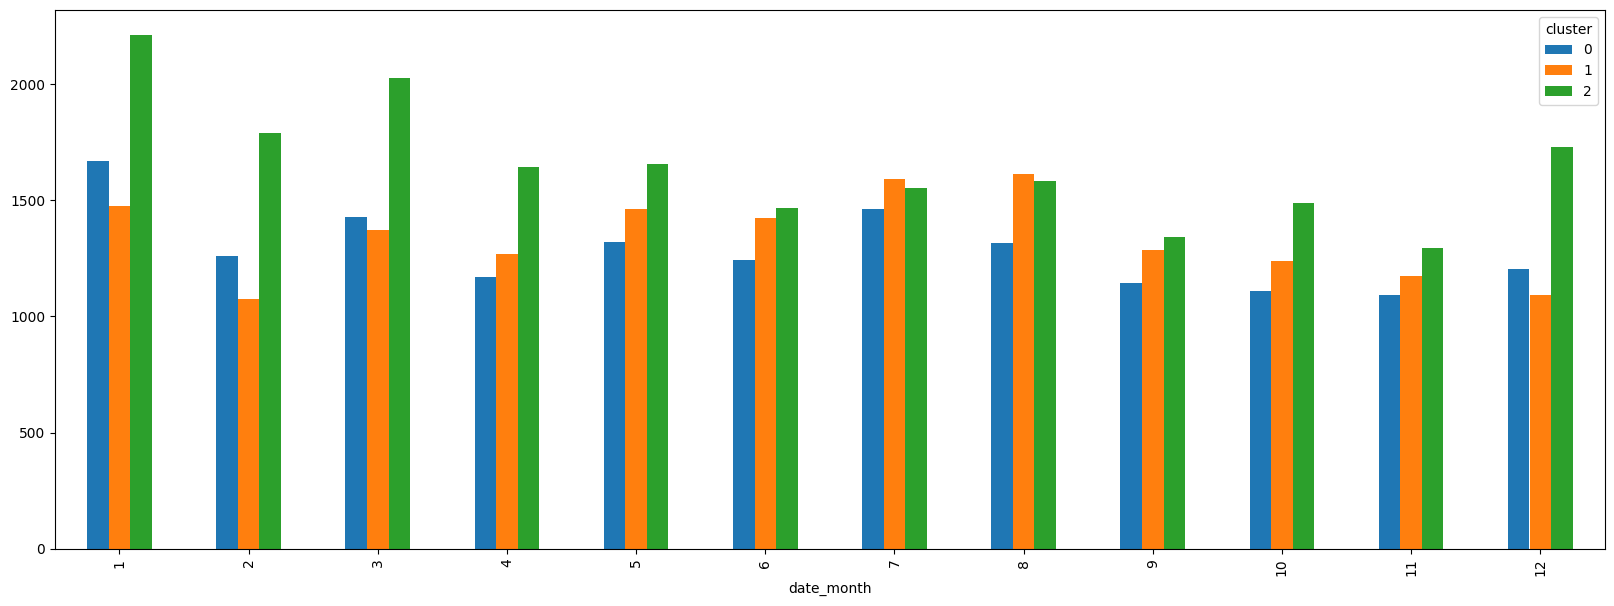

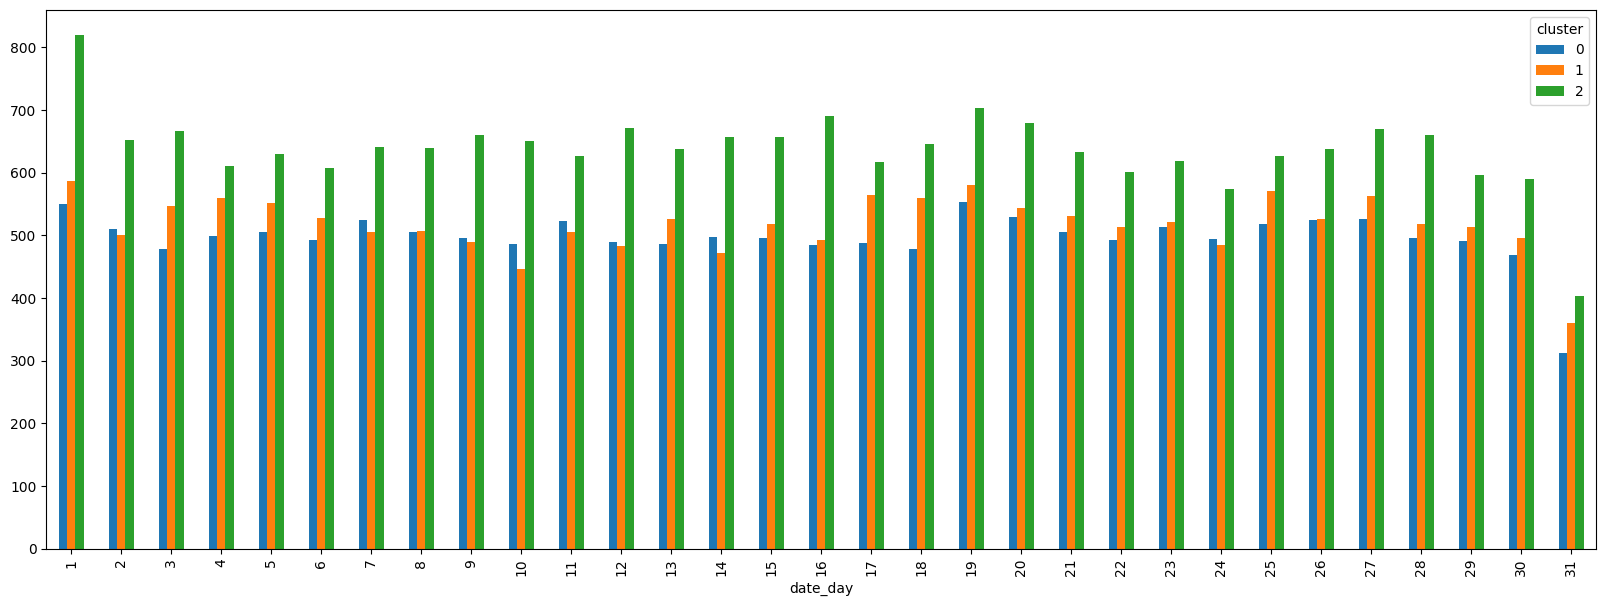

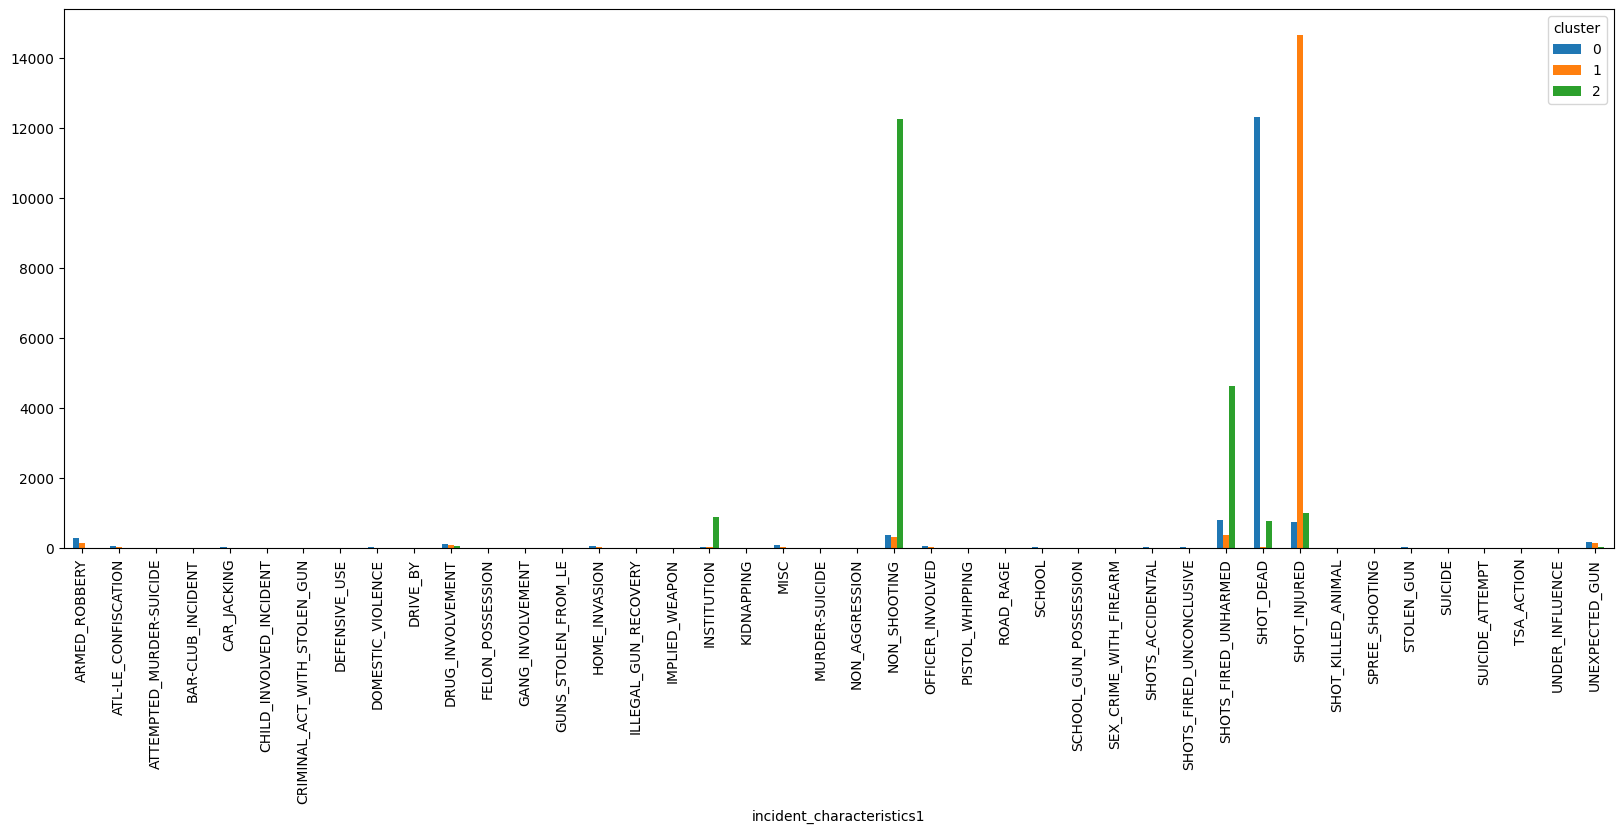

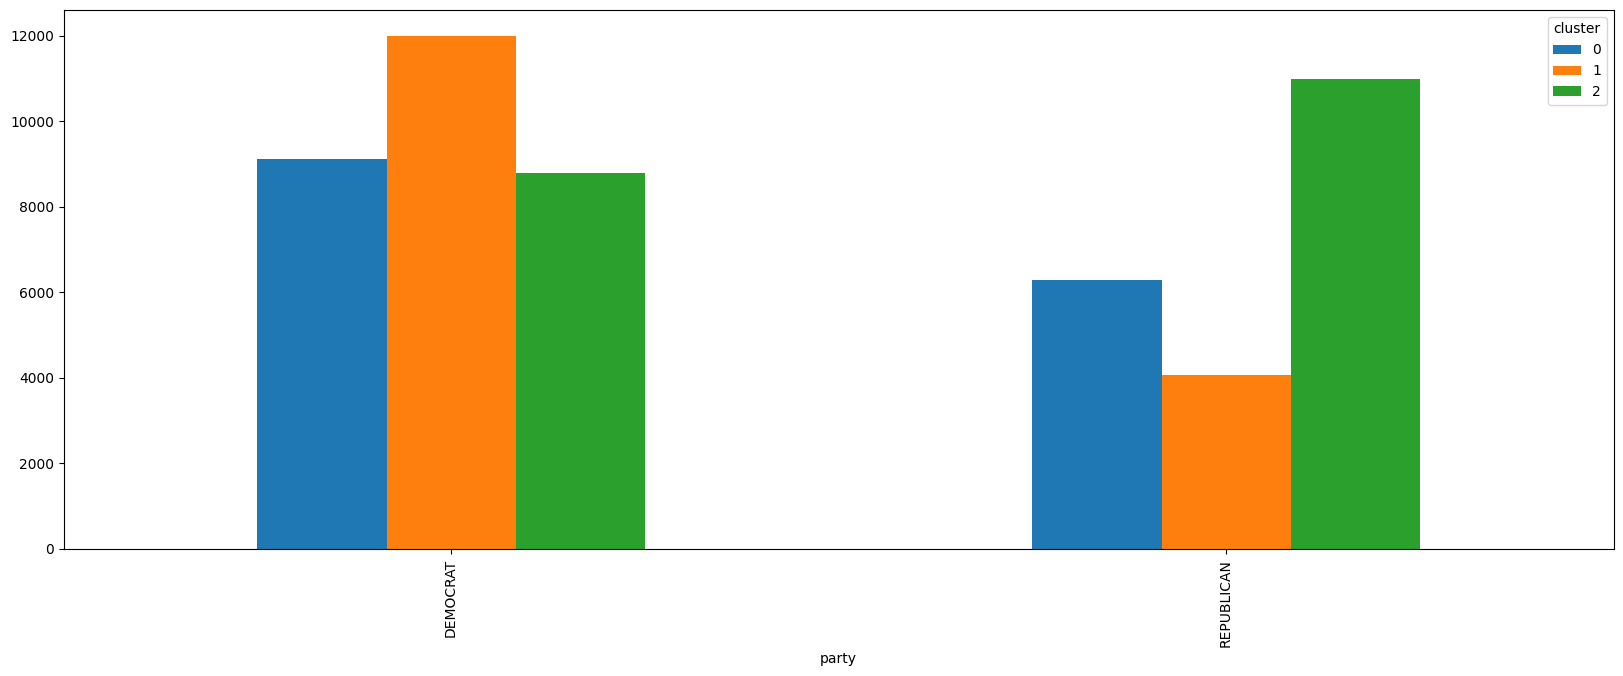

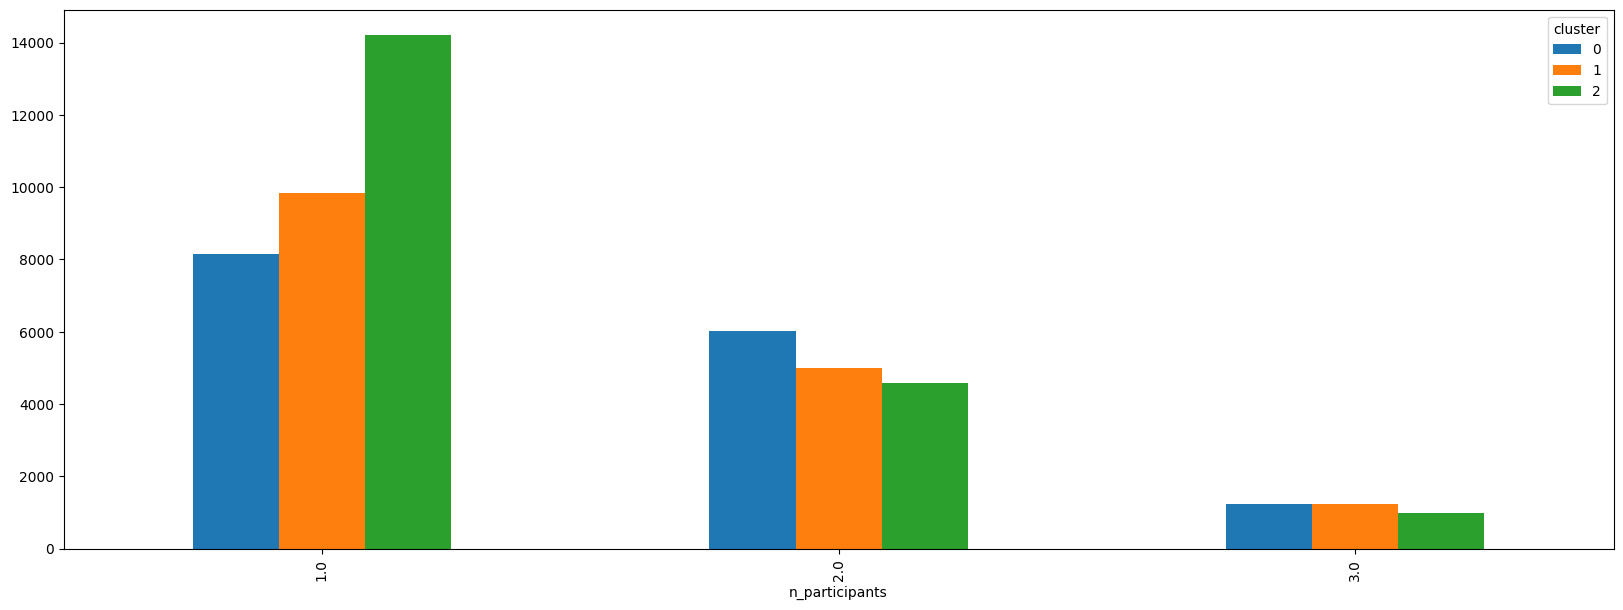

In [6]:


w_clusters = final_clean.copy()
n_w_clusters = w_clusters.select_dtypes(include=['float64', 'int64'])
n_w_clusters_vals = scaler.inverse_transform(n_w_clusters)
n_w_clusters = pd.DataFrame(n_w_clusters_vals, columns=n_w_clusters.columns)
w_clusters[n_w_clusters.columns] = n_w_clusters
w_clusters['cluster'] = kmeans.labels_
w_clusters = w_clusters.sort_values(by=['cluster'])

o = w_clusters.select_dtypes(include=['float64', 'int64']).columns

cats = ['state', 'date_month', 'date_day', 'incident_characteristics1', 'party', 'n_participants']
for cat in cats:
    xt = pd.crosstab(w_clusters[cat], w_clusters['cluster'])
    xt['total'] = xt.sum(axis=1)
    del xt['total']
    xt = xt.sort_index()
    xt.plot.bar(stacked=False, figsize=(20, 7))
    plt.show();

/tmp/ipykernel_424633/2119410640.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_scaled['cluster'] = kmeans.labels_


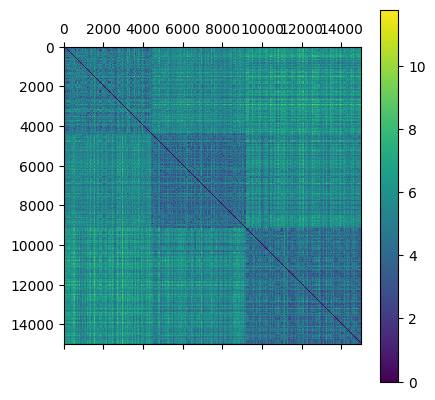

In [10]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

numeric_scaled['cluster'] = kmeans.labels_

sample = numeric_scaled.sample(n=15000).copy()

sample = sample.sort_values(by=['cluster'])

# Calculate the Euclidean distance matrix
euclidean_distances = pdist(sample, metric='euclidean')

# reshape the distances into a square matrix
euclidean_distances = squareform(euclidean_distances)

plt.matshow(euclidean_distances)
plt.colorbar()
plt.show()

# -----------------------------------------------------------------------------------------------------------------------------

# D-BSCAN CLUSTERING

In [11]:
# Number of incidents per state (descending order)
print(final_clean['state'].value_counts())

state
ILLINOIS          3435
FLORIDA           3297
NEW YORK          3273
OHIO              3081
PENNSYLVANIA      2925
NORTH CAROLINA    2379
GEORGIA           2324
SOUTH CAROLINA    1966
NEW JERSEY        1950
TEXAS             1947
TENNESSEE         1940
MASSACHUSETTS     1809
INDIANA           1612
ALABAMA           1506
LOUISIANA         1398
MISSOURI          1394
MICHIGAN          1361
VIRGINIA          1300
KENTUCKY          1135
MISSISSIPPI       1035
CONNECTICUT       1030
WISCONSIN         1022
MARYLAND          1015
ARKANSAS           988
DELAWARE           866
IOWA               652
NEBRASKA           544
COLORADO           479
KANSAS             463
WEST VIRGINIA      435
NEW MEXICO         335
OKLAHOMA           327
RHODE ISLAND       294
NEW HAMPSHIRE      272
ARIZONA            263
MAINE              253
MINNESOTA          248
NORTH DAKOTA       150
UTAH               146
SOUTH DAKOTA       124
MONTANA            113
VERMONT             94
WYOMING             50
IDAHO

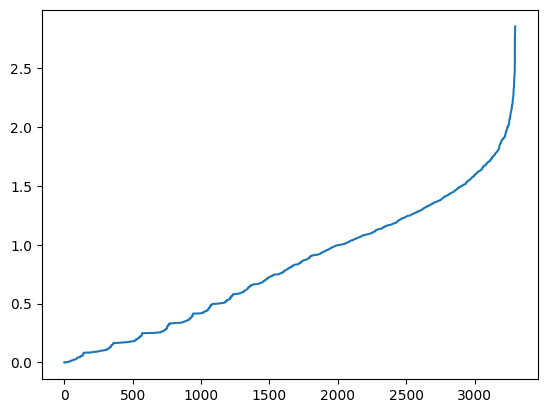

In [12]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Pick only FLORIDA state and remove objects
db_scaled = final_clean.copy()
per_state = db_scaled[db_scaled['state'] == 'FLORIDA']
numeric_cols = per_state.select_dtypes(include=['float64', 'int64']).columns

numeric_db = per_state[numeric_cols]

# NN
nn = NearestNeighbors(n_neighbors=2*numeric_db.shape[1])
nn.fit(numeric_db)
distances, indices = nn.kneighbors(numeric_db)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()


[-1  0  1  2  3  4]
(3297,)
(3297, 25)


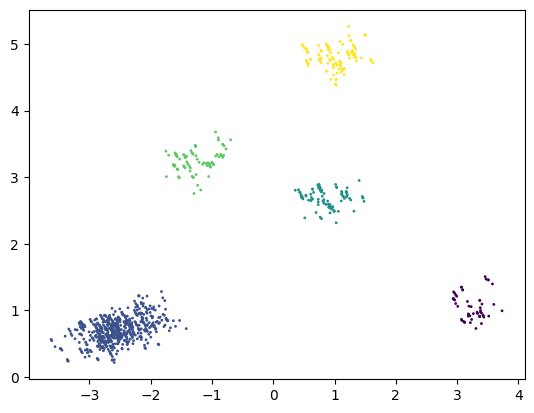

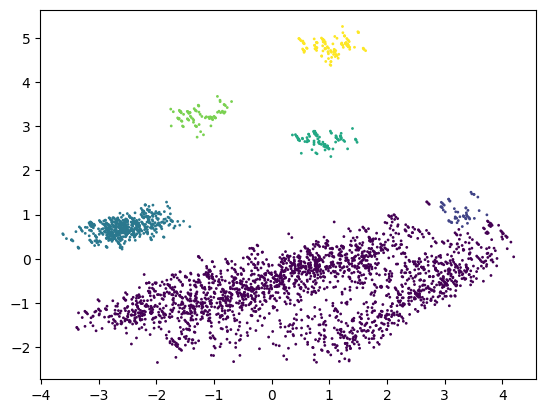

In [32]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#we use the epsilon value of 1.8 and the minimum number of samples of 2 times the number of dimensions
dbs = DBSCAN(eps=1.5, min_samples=2*numeric_db.shape[1], n_jobs=6)
dbs.fit(numeric_db)
labels = dbs.labels_
print(np.unique(labels))
print(labels.shape)
print(numeric_db.shape)

# PCA
pca = PCA(n_components=2, random_state=42)
numeric_pca = pca.fit_transform(numeric_db)

filtered_data = numeric_pca[labels != -1]
filtered_labels = labels[labels != -1]

plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=1, c=filtered_labels)
plt.show()


plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], s=1, c=labels)
plt.show()

# Add cluster labels to w_clusters
per_state.loc[per_state['state'] == 'FLORIDA', 'cluster'] = labels

/tmp/ipykernel_424633/1670137055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_db['cluster'] = labels


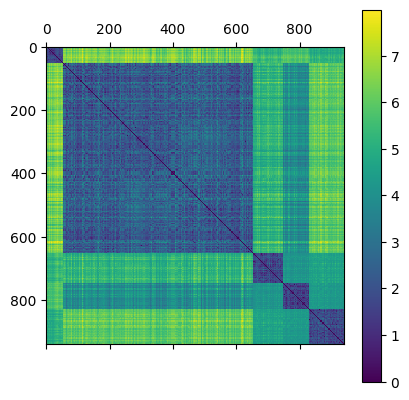

In [33]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

numeric_db['cluster'] = labels

sample = numeric_db.copy()
sample = sample[labels != -1]

sample = sample.sort_values(by=['cluster'])

# Calculate the Euclidean distance matrix
euclidean_distances = pdist(sample, metric='euclidean')

# reshape the distances into a square matrix
euclidean_distances = squareform(euclidean_distances)

plt.matshow(euclidean_distances)
plt.colorbar()
plt.show()

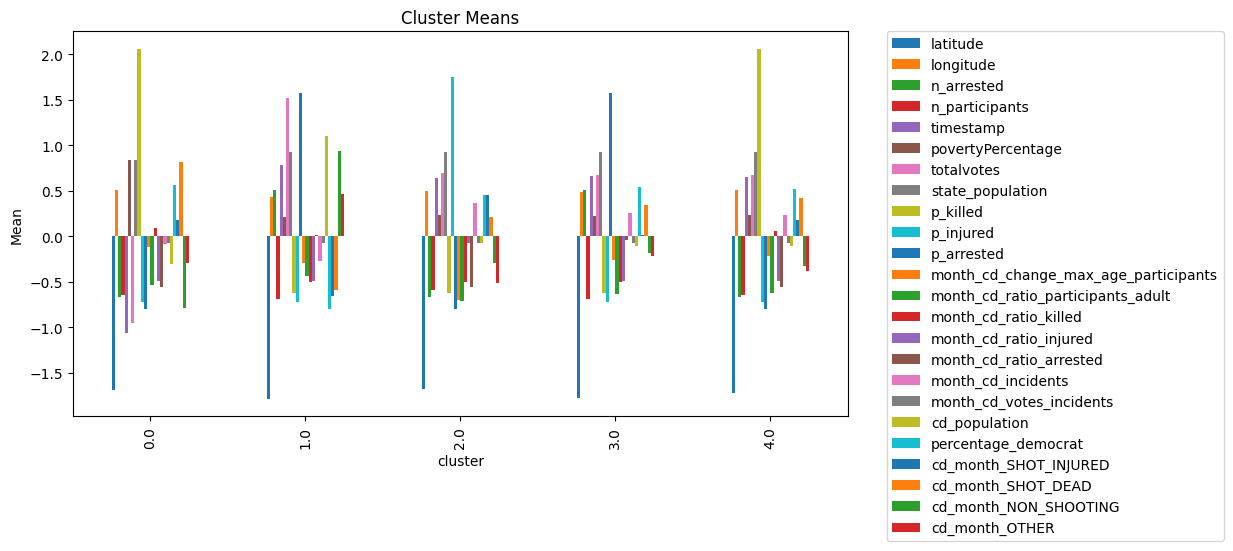

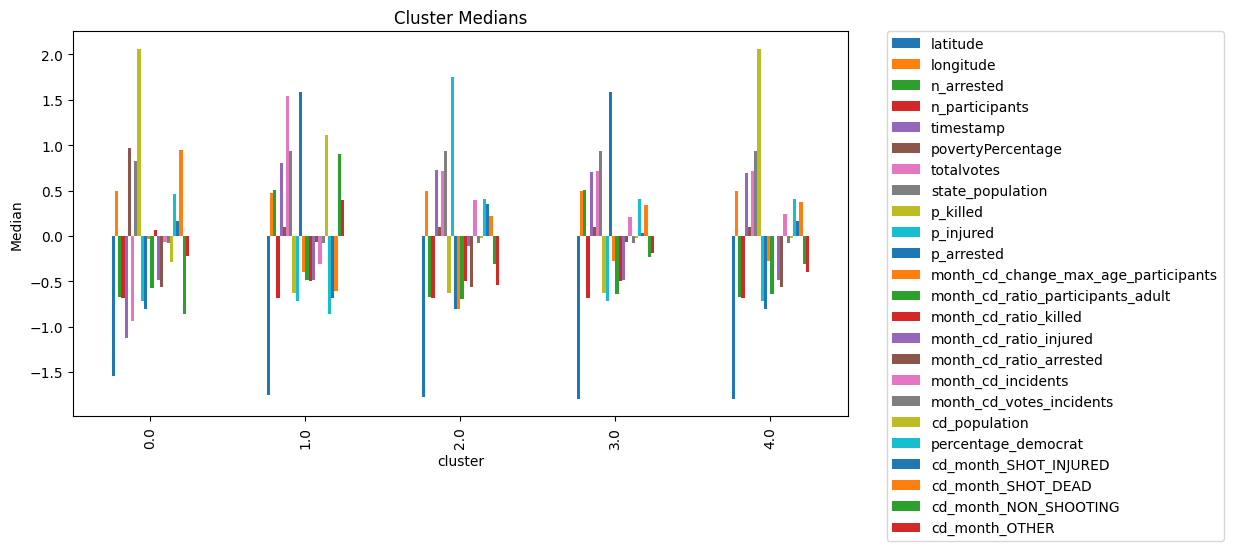

In [34]:
per_state_num = per_state.select_dtypes(include=['float64', 'int64'])
per_state_num = per_state_num[per_state_num['cluster'] != -1]
cluster_means = per_state_num.groupby('cluster').mean()
cluster_medians = per_state_num.groupby('cluster').median()
# 
# Calculate the difference between clusters
cluster_diff = cluster_means - cluster_medians
# 

import matplotlib.pyplot as plt

# Plotting the cluster means
plt.figure(figsize=(10, 5))
plt.title('Cluster Means')
plt.xlabel('Features')
plt.ylabel('Mean')
cluster_means.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Plotting the cluster medians
plt.figure(figsize=(10, 5))
plt.title('Cluster Medians')
plt.xlabel('Features')
plt.ylabel('Median')
cluster_medians.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



## Hierarchical clustering

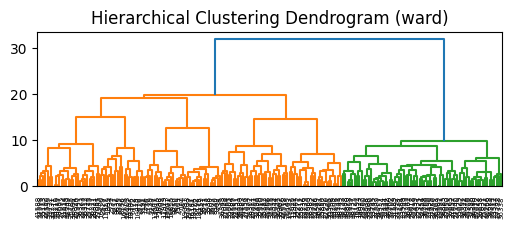

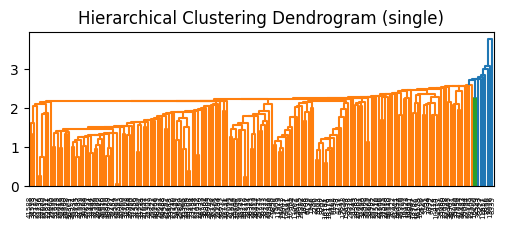

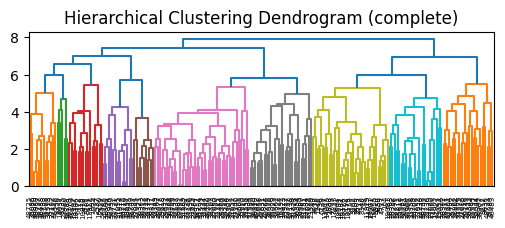

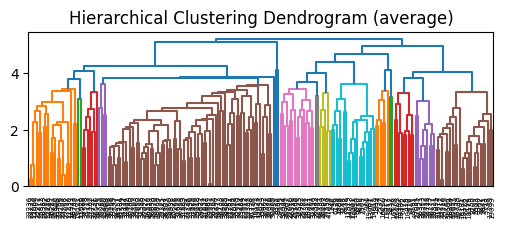

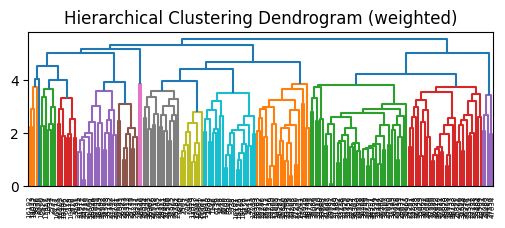

In [35]:
num_hierr = final_clean.copy()
num_hierr = num_hierr[num_hierr['state'] == 'FLORIDA']
num_hierr = num_hierr.select_dtypes(include=['float64', 'int64'])
num_hierr = num_hierr.sample(n=200)

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

linkeds = {}
for method in ['ward', 'single', 'complete', 'average', 'weighted']:
    linked = linkage(num_hierr, method=method)

    plt.figure(figsize=(6, 2))
    d = dendrogram(linked,
               orientation='top',
               labels=num_hierr.index,
               distance_sort='descending',
               show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram ({})'.format(method))
    plt.show()
    linkeds[method] = linked





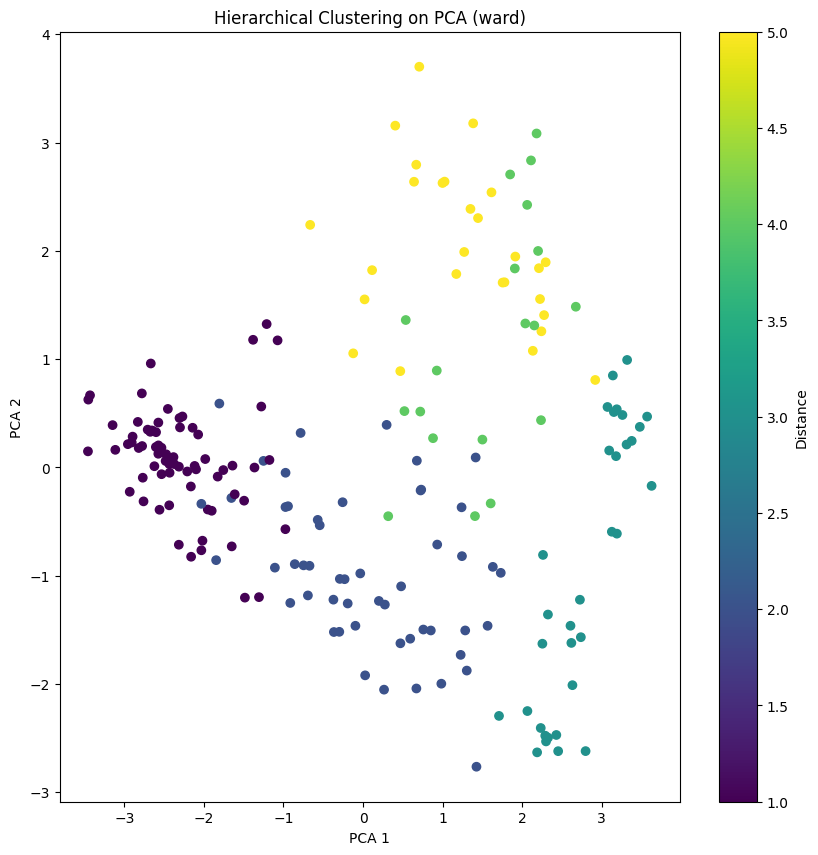

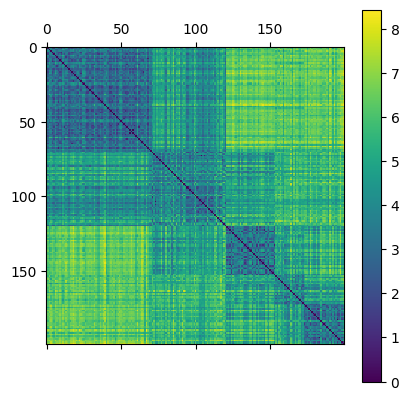

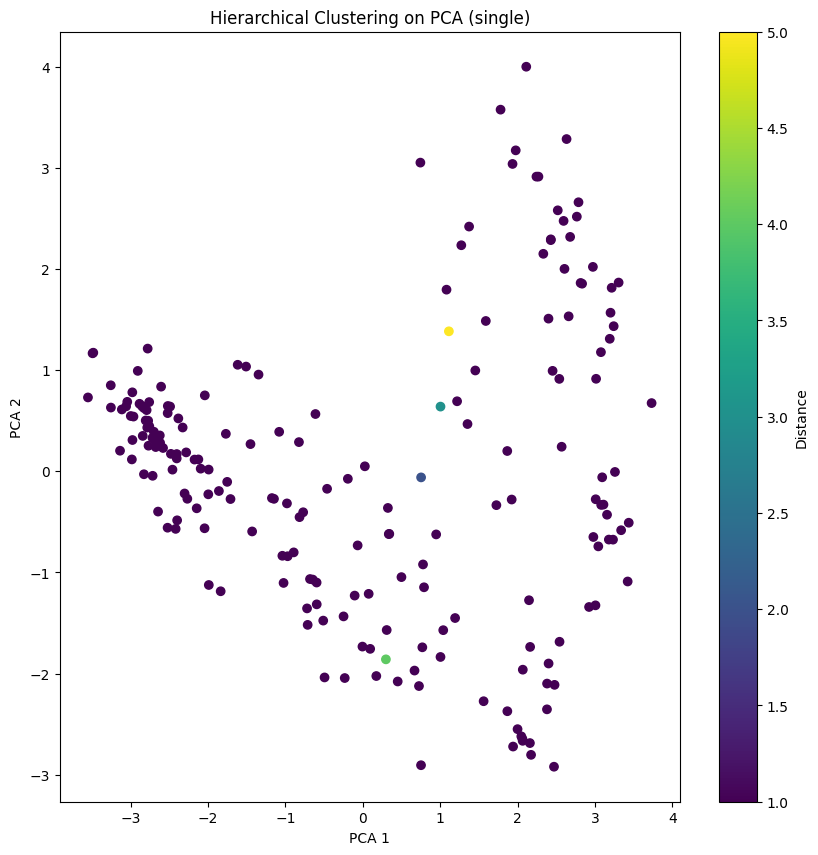

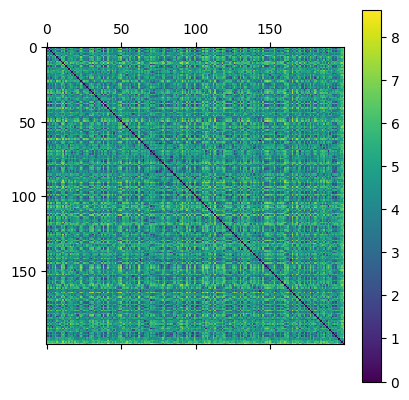

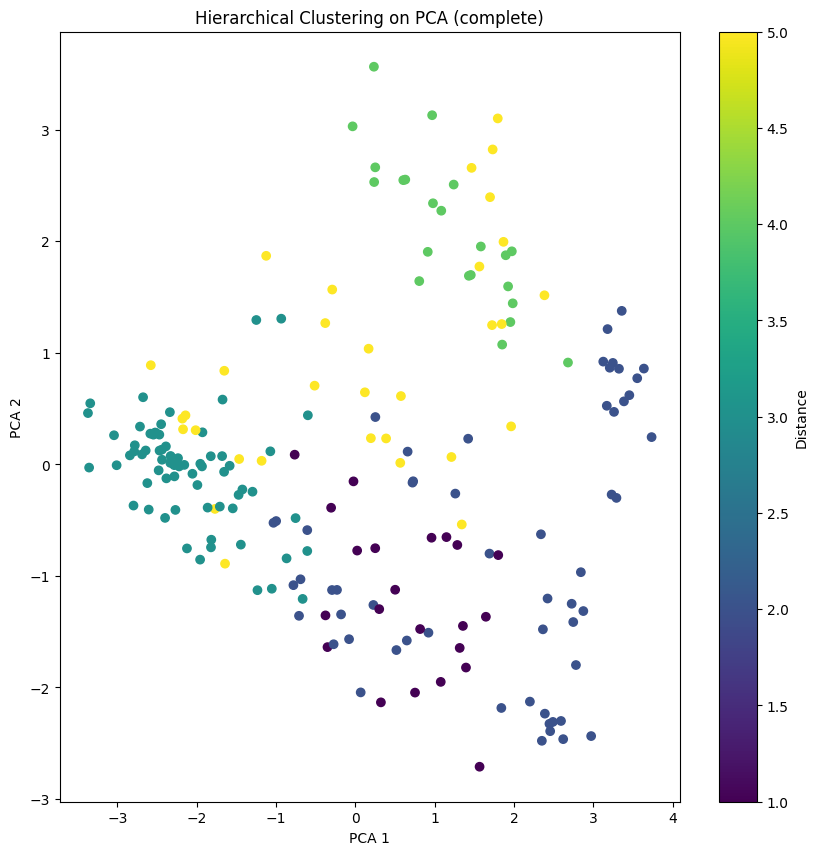

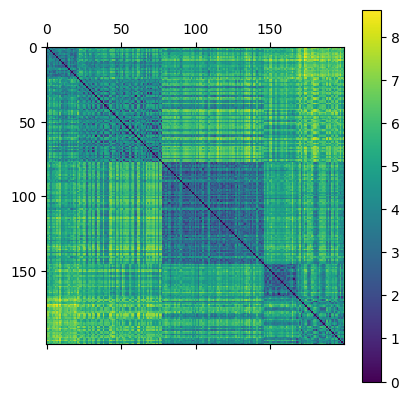

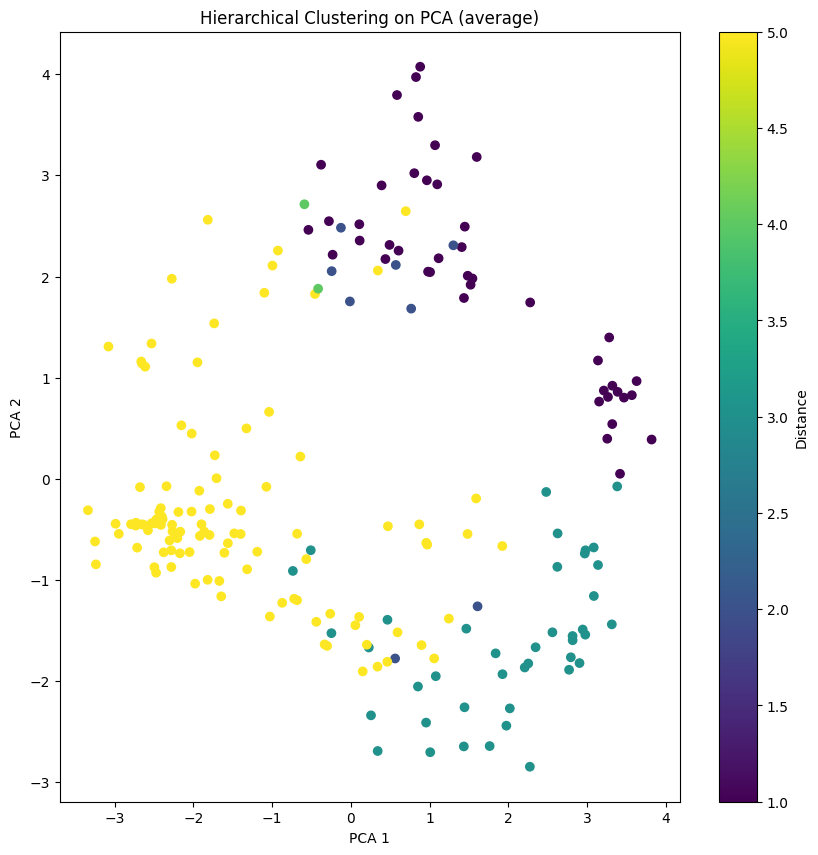

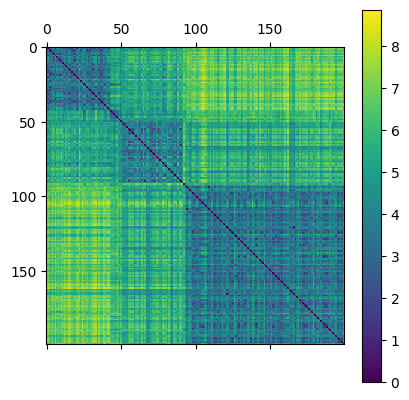

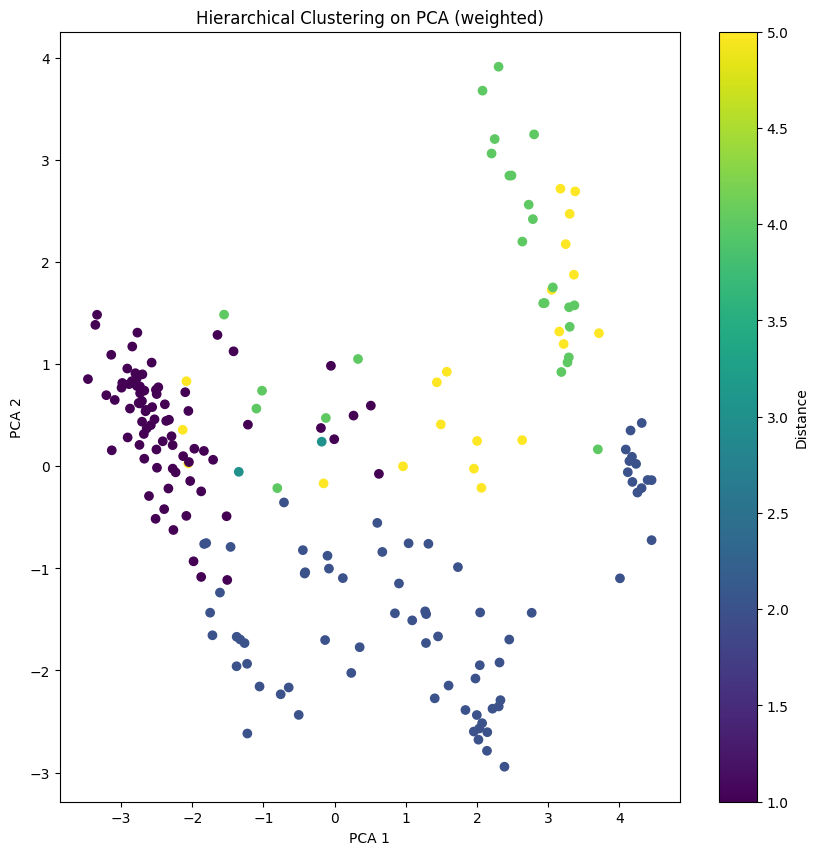

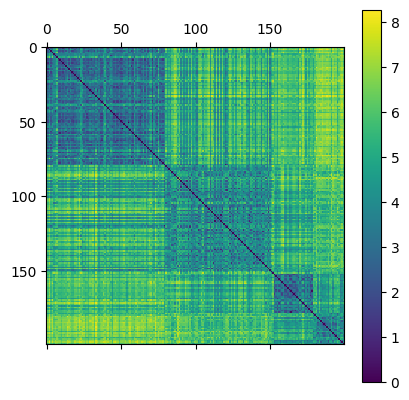

In [37]:

for method in linkeds:
    linked = linkeds[method]
    clusters = fcluster(linked, 5, criterion='maxclust')

    # Perform PCA
    pca = PCA(n_components=2)
    num_hierr_pca = pca.fit_transform(num_hierr)

    # Plot the result on PCA
    plt.figure(figsize=(10, 10))
    plt.scatter(num_hierr_pca[:, 0], num_hierr_pca[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Hierarchical Clustering on PCA ({})'.format(method))
    plt.colorbar(label='Distance')
    plt.show()

    from scipy.spatial.distance import pdist, squareform
    import numpy as np

    num_hierr['cluster'] = clusters

    sample = num_hierr.copy()

    sample = sample.sort_values(by=['cluster'])

    # Calculate the Euclidean distance matrix
    euclidean_distances = pdist(sample, metric='euclidean')

    # reshape the distances into a square matrix
    euclidean_distances = squareform(euclidean_distances)

    plt.matshow(euclidean_distances)
    plt.colorbar()
    plt.show()

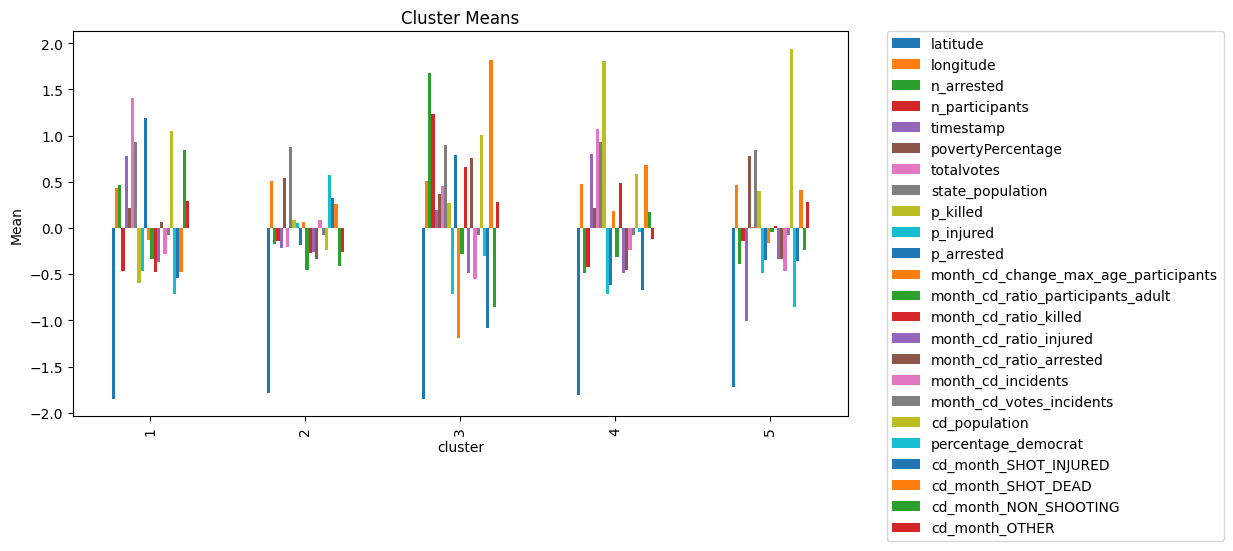

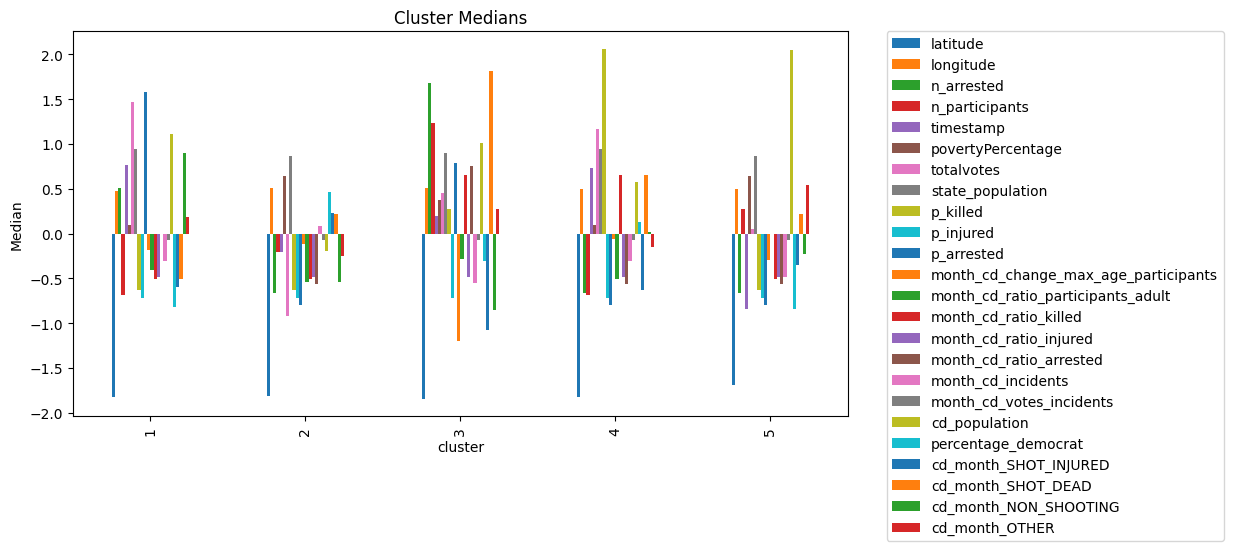

In [38]:
cluster_means = num_hierr.groupby('cluster').mean()
cluster_medians = num_hierr.groupby('cluster').median()
# 
# Calculate the difference between clusters
cluster_diff = cluster_means - cluster_medians
# 

import matplotlib.pyplot as plt

# Plotting the cluster means
plt.figure(figsize=(10, 5))
plt.title('Cluster Means')
plt.xlabel('Features')
plt.ylabel('Mean')
cluster_means.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# move legend outside of the plot


# Plotting the cluster medians
plt.figure(figsize=(10, 5))
plt.title('Cluster Medians')
plt.xlabel('Features')
plt.ylabel('Median')
cluster_medians.plot(kind='bar', ax=plt.gca())
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



## k-SubMix

In [39]:
def cost(p1, p2, idx_num, idx_cat, gamma):
    # numerical cost
    cost_num = np.sum((p1[idx_num] - p2[idx_num])**2)
    # categorical cost
    cost_cat = np.sum(p1[idx_cat] != p2[idx_cat])
    return cost_num + gamma * cost_cat

In [40]:
from k_SubMix import kSubMix
from sklearn.metrics import silhouette_score

ds = final_clean.copy()
ds = ds.sample(n=1000, random_state=0)

cat_cols = ['date_month', 'date_day', 'congressional_district', 'state', 'incident_characteristics1', 'city_or_county', 'party']
# index of numerical columns
index_num_list = [ds.columns.get_loc(col) for col in ds.columns if col not in cat_cols]
# index of categorical columns
index_cat_list = [ds.columns.get_loc(col) for col in cat_cols]

index_num_list.sort()
index_cat_list.sort()

print(index_cat_list)
print(index_num_list)

# map objects to integers
for col in cat_cols:
    ds[col] = ds[col].astype('category').cat.codes

dataset = ds.values
numeric = dataset[:, index_num_list]
categorical = dataset[:, index_cat_list]

GAMMA = 1.5

ksms = {}

for k in range(2, 5):
    ksms[k] = {}
    print('k =', k)
    for gamma in [0, .5, 1, 1.5]:
        print('gamma =', gamma)
        ksm = kSubMix([k, 1], max_iter=50, gamma = gamma, earlyStoppingNMI=.90)
        ksm.fit(dataset, numeric, categorical, None)
        num_clustered = np.array(index_num_list)[ksm.Pn[0]]
        cat_clustered = np.array(index_cat_list)[ksm.Pc[0]]
        print(ksm.labels[0])
        print(f'ksm.labels = {len(ksm.labels[0])}')
        ss = silhouette_score(dataset, ksm.labels[0], metric=lambda u, v: cost(u, v, num_clustered, cat_clustered, gamma))
        ksms[k][gamma] = (ksm, ss)


# ksm = kSubMix([3, 1], max_iter=50, gamma = GAMMA, earlyStoppingNMI=.99)
# ksm.fit(dataset, numeric, categorical, None)



[24, 25, 26, 27, 28, 29, 30]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
k = 2
gamma = 0
0
-----
scatter_cat: [array([914.16925347, 956.54543538, 906.55229569, 599.19393762,
       965.15120258, 990.43297815, 444.58166691]), array([915.276, 961.124, 907.328, 755.126, 966.25 , 993.664, 483.438])]
-----
-----
scatter_cat: [array([914.35479618, 956.62229686, 906.63592664, 590.43150427,
       965.15983758, 990.50822857, 445.22419773]), array([915.276, 961.124, 907.328, 755.126, 966.25 , 993.664, 483.438])]
-----
Iterations at exit: 3
[1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1
 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1
 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0
 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 

In [41]:
silhs = []
for k in ksms:
    for gamma in ksms[k]:
        silhs.append((k, gamma, ksms[k][gamma][1]))

silhs = pd.DataFrame(silhs, columns=['k', 'gamma', 'silhouette'])
silhs = silhs.sort_values(by=['silhouette'], ascending=False)
silhs

k  gamma  silhouette
0   2    0.0    0.409109
6   3    1.0    0.373104
2   2    1.0    0.365199
4   3    0.0    0.299411
3   2    1.5    0.294986
7   3    1.5    0.244128
5   3    0.5    0.174972
9   4    0.5    0.164751
1   2    0.5    0.159195
10  4    1.0    0.149854
11  4    1.5    0.112029
8   4    0.0    0.093427

cluster
0    560
1    440
Name: count, dtype: int64
[array([21, 11,  7,  2, 19, 12, 22, 10,  9,  8, 20]), array([ 1,  3,  4,  6, 16, 15, 17, 13,  0, 14, 23, 18,  5])]


<Figure size 1000x1000 with 0 Axes>

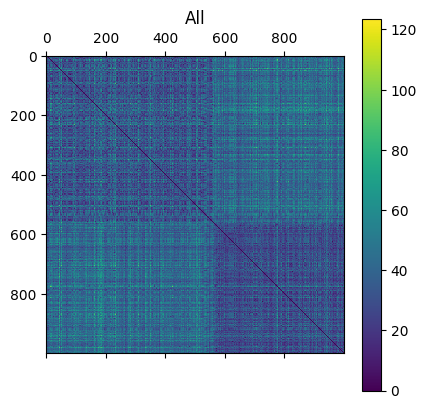

<Figure size 1000x1000 with 0 Axes>

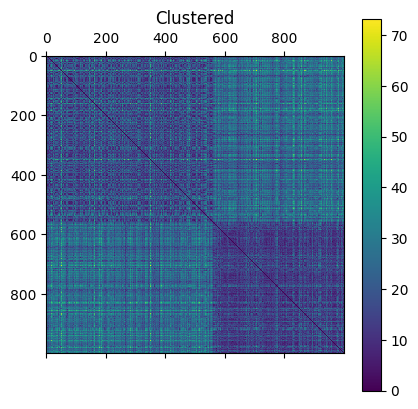

<Figure size 1000x1000 with 0 Axes>

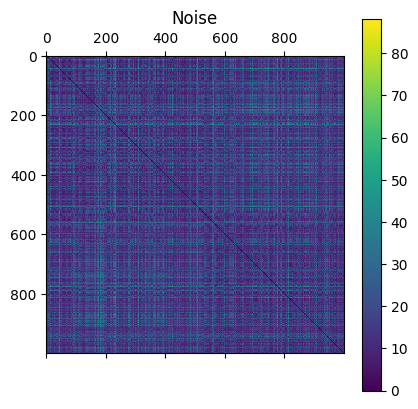

In [46]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

ksm = ksms[2][1][0]

dsn = ds.copy()
# dsn = dsn.select_dtypes(include=['float64', 'int64'])

dsn['cluster'] = ksm.labels[0]

print(dsn['cluster'].value_counts())

sample = dsn.copy()
# sample = sample.sample(n=1000, random_state=0)

sample = sample.sort_values(by=['cluster']).copy()

del sample['cluster']

print(ksm.Pn)

# Calculate the Euclidean distance matrix
num_clustered = np.array(index_num_list)[ksm.Pn[0]]
cat_clustered = np.array(index_cat_list)[ksm.Pc[0]]
num_noise = np.array(index_num_list)[ksm.Pn[1]]
cat_noise = np.array(index_cat_list)[ksm.Pc[1]]
distances = pdist(sample, metric=lambda u, v: cost(u, v, index_num_list, index_cat_list, GAMMA))
distances_clustered = pdist(sample, metric=lambda u, v: cost(u, v, num_clustered, cat_clustered, GAMMA))
distances_noise = pdist(sample, metric=lambda u, v: cost(u, v, num_noise, cat_noise, GAMMA))

# reshape the distances into a square matrix
distances = squareform(distances)
distances_clustered = squareform(distances_clustered)
distances_noise = squareform(distances_noise)

plt.figure(figsize=(10, 10))
plt.matshow(distances)
plt.title('All')
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
plt.matshow(distances_clustered)
plt.title('Clustered')
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
plt.matshow(distances_noise)
plt.title('Noise')
plt.colorbar()
plt.show()

In [47]:
print(ksm.Pn)
print(ksm.Pc)

[array([21, 11,  7,  2, 19, 12, 22, 10,  9,  8, 20]), array([ 1,  3,  4,  6, 16, 15, 17, 13,  0, 14, 23, 18,  5])]
[array([4, 6, 2, 1]), array([0, 5, 3])]


In [48]:
Pc = np.concatenate((num_clustered, cat_clustered))

print(ds.columns[Pc])

Pn = np.concatenate((num_noise, cat_noise))

print(ds.columns[Pn])

Index(['cd_month_SHOT_DEAD', 'month_cd_change_max_age_participants',
       'state_population', 'n_arrested', 'percentage_democrat',
       'month_cd_ratio_participants_adult', 'cd_month_NON_SHOOTING',
       'p_arrested', 'p_injured', 'p_killed', 'cd_month_SHOT_INJURED',
       'date_day', 'party', 'congressional_district', 'state'],
      dtype='object')
Index(['longitude', 'n_participants', 'timestamp', 'totalvotes',
       'month_cd_incidents', 'month_cd_ratio_arrested',
       'month_cd_votes_incidents', 'month_cd_ratio_killed', 'latitude',
       'month_cd_ratio_injured', 'cd_month_OTHER', 'cd_population',
       'povertyPercentage', 'date_month', 'city_or_county',
       'incident_characteristics1'],
      dtype='object')
